In [1]:
import torch 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import datetime

pd.options.display.max_rows=50
pd.set_option('display.float_format', '{:.4f}'.format)

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
output_lst = []
stock_prices = yf.download(['SPY', '^N225', '^VIX'], auto_adjust=True, start='2006-01-01', end='2023-01-01', interval='1d')
stock_prices_1h = yf.download(['SPY', '^FTSE'], auto_adjust=True, start='2021-02-07', end='2023-02-05', interval='1h')['Close'].rename(columns={'^FTSE': 'FTSE'}).reset_index()
cpi = pd.read_csv('datastores/1year-yield-csv/CPI.csv', sep=',', parse_dates=['DATE']).rename(columns={'CORESTICKM159SFRBATL': 'cpi'}).set_index('DATE')
t_bill_1y = pd.read_csv('datastores/1year-yield-csv/1year_yield.csv', sep=',', parse_dates=['DATE']).rename(columns={'DGS1': 't_bill_1y'}).set_index('DATE')
gdp = pd.read_csv('datastores/1year-yield-csv/GDP.csv', sep=',', parse_dates=['DATE'])\
                                                                  .rename(columns={'GDP': 'gdp'})\
                                                                  .set_index('DATE')\
                                                                  .pct_change()
unemployment = pd.read_csv('datastores/1year-yield-csv/UNRATE.csv', sep=',', parse_dates=['DATE']).rename(columns={'UNRATE': 'unemployment'}).set_index('DATE')
spread_10y_2y = pd.read_csv('datastores/1year-yield-csv/T10Y2Y.csv', sep=',', parse_dates=['DATE']).rename(columns={'T10Y2Y':'spread_10y_2y'}).set_index('DATE')

In [ ]:
#features close_SPY | vix | volume_SPY | ret_close_close_SPY | ret_close_open_SPY | cpi | t_bill_1y | gdp | unemployment | spread_10y_2y | ret_N225
#daily shifted
#class y is in the same row with the features from the previous day

flag_ret_close_open = False
flag_ftse = False #if ftse is included to the features
#ftse
if flag_ftse:
    gr_stock_prices_1h = stock_prices_1h.groupby([pd.Grouper(key='Datetime', freq='1d')]).count()
    mask_dates = gr_stock_prices_1h.query('SPY > 0 & FTSE > 0').index
    stock_prices_1h.index = stock_prices_1h['Datetime'].map(lambda x: x.date())
    ftse = pd.DataFrame()
    for date in mask_dates:
        ftse_prices_1d = stock_prices_1h.loc[stock_prices_1h.index == date][:7]['FTSE'].dropna()
        ftse_return = np.log(ftse_prices_1d.iloc[-1] / ftse_prices_1d.iloc[0])
        ftse = ftse.append({'date': date, 'ret_ftse': ftse_return}, ignore_index=True)
    ftse = ftse.set_index('date')
    ftse.index = ftse.index.date
    ftse['ret_ftse'] = ftse['ret_ftse'].astype(float)

#spy
spy = stock_prices['Open'][['SPY']].rename(columns={'SPY': 'open_SPY'})
spy[['close_SPY', 'vix']] = stock_prices['Close'][['SPY', '^VIX']]
spy['volume_SPY'] = stock_prices['Volume']['SPY']
spy.index = spy.index.date
spy = spy.dropna()
if flag_ret_close_open:
    spy['y'] = np.log(spy['close_SPY'] / spy['open_SPY'])
    spy['class_y'] = spy['y'].map(lambda x: 1 if x > 0 else 0)
    spy['ret_close_close'] = np.log(spy['close_SPY']).diff().shift()
    spy['ret_close_open'] = np.log(spy['open_SPY'] / spy['close_SPY'].shift())
else:
    spy['y'] = np.log(spy['close_SPY'] / spy['close_SPY'].shift())
    spy['class_y'] = spy['y'].map(lambda x: 1 if x > 0 else 0)
    spy['ret_close_close'] = spy['y'].shift()

spy[['close_sh', 'vix_sh', 'volume_sh']] = spy[['close_SPY', 'vix', 'volume_SPY']].shift()

#n225
n225 = stock_prices['Close'][['^N225']]
n225.index = n225.index.date + datetime.timedelta(1)
n225 = n225.dropna()
n225['ret_n225'] = np.log(n225).diff()

df = spy.copy()
df.index = pd.to_datetime(df.index)

#merging 
df = df.merge(n225, how='left', left_index=True, right_index=True)\
        .merge(cpi, how='outer', left_index=True, right_index=True)\
        .merge(t_bill_1y, how='outer', left_index=True, right_index=True)\
        .merge(gdp, how='outer', left_index=True, right_index=True)\
        .merge(unemployment, how='outer', left_index=True, right_index=True)\
        .merge(spread_10y_2y, how='outer', left_index=True, right_index=True)\

#filling
df[['t_bill_1y', 'spread_10y_2y']] = df[['t_bill_1y', 'spread_10y_2y']].replace('.', np.NaN)\
                                                                       .astype(float)\
                                                                       .interpolate(method='linear')\
                                                                       .shift() #daily data
df[['cpi', 'unemployment', 'gdp']] = df[['cpi', 'unemployment', 'gdp']].astype(float)\
                                                                       .fillna(method='ffill')

#normalization
df = df.dropna()
normalized_features = ['close_sh', 'vix_sh', 'volume_sh', 'cpi', 't_bill_1y', 'gdp', 'unemployment', 'spread_10y_2y']
scaler = StandardScaler()
scaler.fit(df[normalized_features])
df[normalized_features] = scaler.transform(df[normalized_features])

#the model features
features =  ['ret_close_close', 'ret_close_open', 'close_sh', 'vix_sh', 'volume_sh', 'ret_n225', 'cpi', 't_bill_1y', 'gdp', 'unemployment', 'spread_10y_2y']
if not flag_ret_close_open:
    features.remove('ret_close_open')
if flag_ftse:
    df = df.merge(ftse, how='inner', left_index=True, right_index=True)
    features.append('ret_ftse')
    
df_feat = df[['class_y'] + features].copy()
df_feat.shape

In [111]:
def plot_graph(*cols, df, test_set, figsize=(11,6)): #cols[0] = train_loss | cols[1] = test_accuracy
    best_accuracy = df[cols[1]].max()
    df = df.set_index('epoch')
    print(f'max_accuracy: {best_accuracy:.3f}')
    predicted_y_best_accuracy = df.query(f'{cols[1]} == {best_accuracy}')['predicted_y'].iloc[0]
    cf_matrix = confusion_matrix(test_set[1].numpy(), predicted_y_best_accuracy)

    df[[cols[0], cols[1]]].plot(figsize=figsize)
    plt.legend([cols[0], cols[1]])
    plt.show()
    
    df[cols[1]].plot(figsize=figsize)
    plt.show()
  
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap = 'Blues', fmt='.2%', xticklabels = ['predicted_down', 'predicted_up'], yticklabels = ['true_down', 'true_up']);
    plt.show()    
    
def create_window_data(df, window_size, cols:list, train_size=0, test_size=0, class_col='class_y', reset_to_zero_cols=False, leave_non_zero_rows=False, reset_flag=False): 
    df = df.copy()
    windows_X = []
    class_y = []

    for i in range(df.shape[0] - window_size + 1):
        if reset_flag:
            cols_reset = [cols[i] for i in reset_to_zero_cols]
            df.loc[i : i + window_size - leave_non_zero_rows, cols_reset] = 0
            windows_X.append(df[cols].iloc[i : (i + window_size)].values)
            class_y.append(df[class_col].iloc[i + window_size - 1])
        else:
            windows_X.append(df[cols].iloc[i : (i + window_size)].values)
            class_y.append(df[class_col].iloc[i + window_size - 1]) #the last row of the window

    windows_X = torch.tensor(windows_X, dtype=torch.float)
    class_y = torch.tensor(class_y, dtype=torch.long)
        
    train_X, train_y = windows_X[:train_size], class_y[:train_size]
    test_X, test_y = windows_X[train_size:(train_size + test_size)], class_y[train_size:(train_size + test_size)]
        
    return list(zip(train_X, train_y)), (test_X, test_y)




class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # out[0] of the last layer: batch_size, seq length, hidden dim -> (batch_size, hidden_dim)
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = out.relu()
        out = self.fc1(out).relu()
        out = self.fc2(out)
        return out


    

def train_plain_validation(df_feat, model_params, plot_graph_flag=False):
    train_set, test_set  = create_window_data(df_feat[model_params['starting_point']:], 
                                              window_size=model_params['window_size'],
                                              cols=model_params['features'],
                                              train_size=model_params['train_size'],
                                              test_size=model_params['test_size'], 
                                              reset_to_zero_cols=model_params['reset_to_zero_cols'],
                                              leave_non_zero_rows=model_params['leave_non_zero_rows'],
                                              reset_flag=model_params['reset_flag'])

    loader = DataLoader(train_set, batch_size=model_params['batch_size'], shuffle=False)
    print(f'test_set proportion: {test_set[1].sum() / test_set[1].shape[0]:.2f}, test_size: {test_set[1].shape[0]}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    model = LSTMNet(input_dim=len(model_params['features']), 
                    hidden_dim=model_params['hidden_dim'], 
                    output_dim=2, 
                    num_layers=model_params['num_layers'],
                    dropout=model_params['dropout'])

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])

    out_data = pd.DataFrame()
    for epoch in range(model_params['epoch']):
        model.train()
        total_loss = 0
        for data in loader:
            train_X, train_y = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            out = model(train_X)

            loss = criterion(out, train_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % model_params['epoch_divisor'] == 0:
            model.eval()
            with torch.no_grad():
                _, predicted_label = torch.max(model(test_set[0].to(device)), 1)
                predicted_label = predicted_label.detach().cpu().numpy()
                accuracy = accuracy_score(test_set[1].numpy(), predicted_label)

            out_data = out_data.append({'epoch': epoch,
                                       'train_loss': total_loss,
                                       'test_accuracy': accuracy, 
                                       'predicted_y': predicted_label}, ignore_index=True)
    if plot_graph:
        plot_graph('train_loss', 'test_accuracy', df=out_data, test_set=test_set)
    return out_data, test_set

n_features: 9
test_set proportion: 0.56, test_size: 100
max_accuracy: 0.640


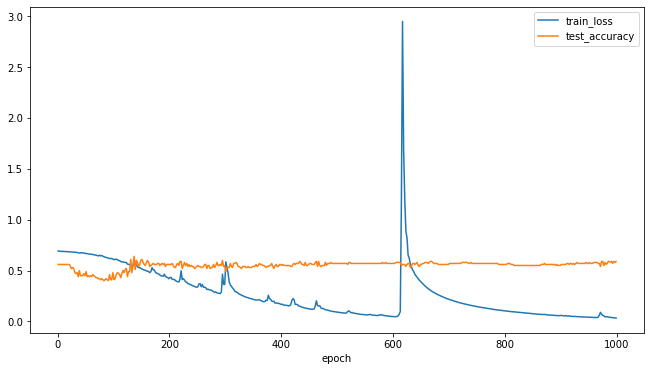

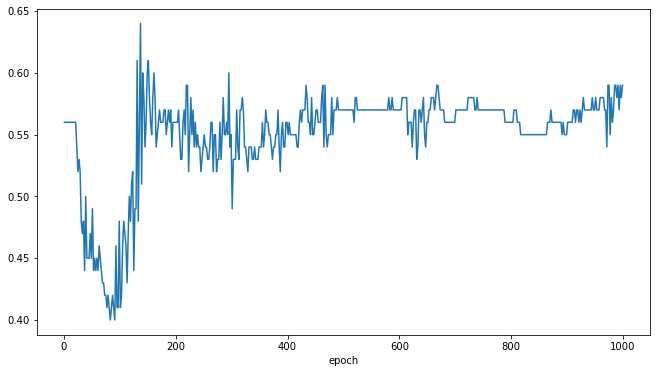

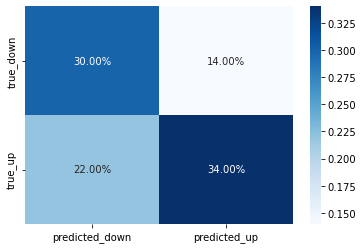

In [116]:
features = ['ret_close_close', 'ret_close_open','volume_sh', 'cpi', 't_bill_1y', 'gdp', 'unemployment', 'close_sh', 'ret_n225']
print(f'n_features: {len(features)}')
model_params = {'hidden_dim': 128, 
                'num_layers': 1,
                'dropout': 0, 
                'learning_rate': .007,
                'starting_point': 100,
                'batch_size': 2800,
                'train_size': 2800,
                'test_size': 100,
                'features': features,
                'window_size': 3,
                'epoch': 1000,
                'epoch_divisor': 2, 
                'reset_to_zero_cols': [],
                'leave_non_zero_rows': 3,
                'reset_flag': False}

out, _ = train_plain_validation(df_feat, model_params, plot_graph_flag=True)